# Q7_LBflowsBGK

修改流场边界条件使之能够模拟如下图所示的圆柱绕流问题。提示：可先将程序中的方柱改为圆柱，然后将圆柱的大小和位置调整至适当数值，接下来调整流动的Reynolds数使流场中能够产生如图所示的涡旋。

![涡旋示意图](https://s2.ax1x.com/2019/05/28/VmHGhq.jpg)

## 第一步：初始化相关参数

我们知道，当液体雷诺数小时作层流运动，雷诺数大时作湍流运动

因此对于本题所需要的效果，适量高的雷诺数是必不可少的

下图分别为雷诺数 10、100、500 的效果图，可以更好说明这点

![不同雷诺数示意](https://s2.ax1x.com/2019/06/06/VdHWHU.jpg)

可以看到雷诺数 100 最合题意

In [1]:
# 导入相关库
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
maxIter = 2400  # 迭代次数
nx = 120  # 横向网格数量
ny = 80  # 纵向网格数量

In [3]:
cx = nx/4  # 圆柱障碍中心横坐标
cy = ny/2  # 圆柱障碍中心纵坐标
r = ny/8  # 圆柱障碍半径

# 圆柱障碍表达式
obstacle = np.fromfunction(lambda x, y: (x-cx)**2+(y-cy)**2 < r**2, (nx, ny))

注：*`numpy.fromfunction` 以函数式创建数组*

In [4]:
Re = 100  # 雷诺数
uLB = 0.04  # 格子速度
nulb = uLB*r/Re  # 黏度
omega = 1.0 / (3.*nulb+0.5)  # 弛豫时间

## 第二步：定义LBGK算法

对于二维问题的处理，通常可使用 D2Q7 及 D2Q9 模型，其示意图如下：

![DnQb](https://s2.ax1x.com/2019/05/28/VmXYOf.png)

本题处理采用了 D2Q9 模型，其中 2 为空间维数，9 是离散速度数

In [5]:
q = 9  # 离散速度数

# 按顺序所对应的速度坐标，以 0 点为中心 [0, 0]
# 坐标第一个参数表示列，第二个参数表示行
c = np.array([[0, 0], [1, 0], [0, -1],
              [-1, 0], [0, 1], [1, -1],
              [-1, -1], [-1, 1], [1, 1]])

平衡分布函数：

$$f_i^{eq}(x)=\omega_i\rho(x)[1+\frac{e_i\cdot u}{c_s^2}+\frac{(e_i\cdot u)^4}{2c_s^2}-\frac{u^2}{2c_s^2}]$$

其中，$\omega_i$ 为权系数，$c_s=\sqrt{RT}$ 为格子声速

In [6]:
# 平衡态分布函数
def equilibrium(rho, u):
    cu = 3.0 * np.dot(c, u.transpose(1, 0, 2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = np.zeros((q, nx, ny))
    for i in range(q):
        feq[i, :, :] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

通过恰当的动量空间离散方法，宏观变量的积分计算形式可以转化为简单的代数形式：

密度：

$$\rho=\sum_i f_i = \sum_i f_i^{eq}$$

速度：

$$\rho u = \sum_i \xi_i f_i = \sum_i \xi_i f_i^{eq}$$

内能：

$$\rho\varepsilon=\frac{1}{2}\sum_i(\xi_i-u)^2f_i=\frac{1}{2}\sum_i(\xi_i-u)^2f_i^{eq}$$

若上述的近似计算成立，需要满足两个守恒原则：

$$f_i \equiv f_i(x,t) \equiv W_if(x,e_i,t)$$

$$f_i^{eq} \equiv f_i^{eq}(x,t) \equiv W_if^{eq}(x,e_i,t)$$

$W_i$ 为权重系数，$e_i$ 为离散速度

转化成含有高斯积分公式计算的一般形式：

$$I=\int{exp(-\frac{\xi^2}{2RT})\psi(\xi)d\xi}=\sum_i W_iexp(-\frac{\xi^2}{2RT})\psi(\xi_i)$$

对于二阶的 $\psi(\xi)$，需要采用三阶 Gauss-Hermite 求积公式

$$I_m=\sum_{j=1}^3\omega_j\zeta_j^m$$

积分点：$\xi_1=-\sqrt{3/2},\xi_2=0,\xi_3=\sqrt{3/2}$

权系数：$\omega1=\sqrt\pi/6,\omega2=2\sqrt\pi/3,\omega3=\sqrt\pi/6$

等温情况时：$c=\sqrt{3RT}$，且 $c_s^2 = c^2/3 = RT$

得 $c_s= 1/\sqrt 3$

则权系数：

$$\omega_i = \frac{\omega_2 \omega_2}{\pi}=\frac{4}{9} \cdots\cdots i=0$$
$$\omega_i = \frac{\omega_1 \omega_2}{\pi},\frac{\omega_2 \omega_1}{\pi},\frac{\omega_3 \omega_2}{\pi},\frac{\omega_2 \omega_3}{\pi}=\frac{1}{9} \cdots\cdots i=1,2,3,4$$
$$\omega_i = \frac{\omega_1 \omega_3}{\pi},\frac{\omega_3 \omega_1}{\pi},\frac{\omega_1 \omega_1}{\pi},\frac{\omega_3 \omega_3}{\pi}=\frac{1}{36} \cdots\cdots i=5,6,7,8$$

In [7]:
# 权系数
w1 = 4/9
w2 = 1/9
w3 = 1/36
t = np.array([w1, w2, w2, w2, w2, w3, w3, w3, w3])

对于静止固体边界，常用的处理方法是对边界上的粒子进行弹回处理，即假设粒子与壁面碰撞后沿粒子原方向的反方向逆转，即：

$$f_{2,5,6}(i,1)=f_{4,7,8}(i,1)$$

在图上表示可见下左图：

![碰撞及边界](https://s2.ax1x.com/2019/05/29/VnutTe.jpg)

按原顺序 [0, 1, 2, ...] 读取的新顺序则为 [0, 3, 4, 1, 2, 7, 8, 5, 6]

In [8]:
noslip = [0, 3, 4, 1, 2, 7, 8, 5, 6]

1997年，Zou 与 He 给出了另外一种补充条件：假设分布函数的非平衡部分在垂直于边界的方向上仍然满足反弹格式，需满足以下四个方程：

$$\begin{cases}
\rho=\sum_\alpha f_\alpha\\
u_0=\frac{1}{\rho}\sum_\alpha f_\alpha e_\alpha\\
0=f_1-f_3+f_5-f_6-f_7+f_8\\
\rho v_0=f_2-f_4+f_5+f_6-f_7-f_8\\
\end{cases}
$$

可得：

$$f_2-f_2^{eq}=f_4-f_4^{eq}$$

In [9]:
i1 = [3, 6, 7]  # 右边界
i2 = [0, 2, 4]  # 中间
i3 = [1, 5, 8]  # 左边界

In [10]:
# 速度入口
vel = np.fromfunction(lambda d, x, y: (1-d)*uLB *
                      (1.0+1e-4*np.sin(y/(ny-1.0)*2*np.pi)), (2, nx, ny))

宏观量：

$$\rho=\sum_{\alpha=0}^{\alpha_{max}}f_{\alpha}, \rho\vec u=\sum_{\alpha=0}^{\alpha_{max}}f_{\alpha}\vec e_{\alpha}$$

In [11]:
def sumpop(fin):
    # 计算宏观密度
    return np.sum(fin, axis=0)

## 第三步：启动循环

对于无外力作用的单松弛（LBGK）模型：

$$f_\alpha(x+e_\alpha\Delta t,t+1)=f_\alpha(x,t)-\frac{[f_\alpha^{eq}(x,t)-f_\alpha(x,t)]}{\tau}$$

碰撞-迁移结构：

1. 初始化分布函数 $f_\alpha(x,t)$

2. 在时刻 $t$ 执行碰撞（Collision）

3. 执行迁移（Streaming）

4. 边界处理

5. 计算宏观量 $\rho,\rho\vec u$

In [12]:
feq = equilibrium(1.0, vel)
fin = feq.copy()

In [13]:
for time in range(maxIter):
    fin[i1, -1, :] = fin[i1, -2, :]  # 右边界流出处理
    rho = sumpop(fin)  # 计算宏观密度和速度
    u = np.dot(c.transpose(), fin.transpose((1, 0, 2)))/rho

    # 左边界处理：从已知速度求解密度
    u[:, 0, :] = vel[:, 0, :]
    rho[0, :] = 1./(1.-u[0, 0, :]) * \
        (sumpop(fin[i2, 0, :])+2.*sumpop(fin[i1, 0, :]))
    feq = equilibrium(rho, u)
    
    # Zou/He边界处理
    fin[i3, 0, :] = fin[i1, 0, :] + feq[i3, 0, :] - feq[i1, 0, :] 
    fout = fin - omega * (fin - feq)  # 碰撞步骤
    for i in range(q):
        fout[i, obstacle] = fin[noslip[i], obstacle]
    for i in range(q):  # 迁移步骤
        fin[i, :, :] = np.roll(
            np.roll(fout[i, :, :], c[i, 0], axis=0), c[i, 1], axis=1)

## 第四步：绘图

In [14]:
obstacle = np.where(obstacle == True)
u[:,obstacle[0],obstacle[1]]=0

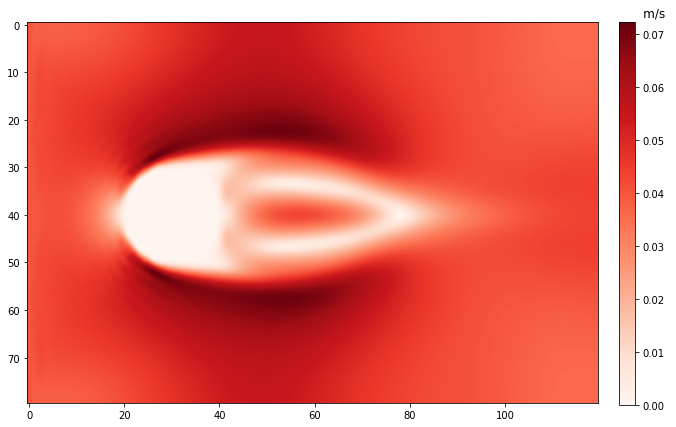

In [15]:
plt.figure(figsize=(11, 7))
plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(),
           cmap=cm.Reds, interpolation='spline36')
cax = plt.axes([0.9, 0.12, 0.02, 0.76],title="               m/s ")
plt.colorbar(cax=cax)

In [16]:
z = np.sqrt(u[0]**2+u[1]**2).transpose()
v1, u1 = np.gradient(z)
v1 = v1*z
u1 = u1*z

In [17]:
v1_cut = v1.max()/10
u1_cut = u1.max()/10

In [18]:
v1_adj = np.where(v1 >= v1_cut)
v1[v1_adj[0],v1_adj[1]]=v1_cut
v1_adj = np.where(v1 <= -v1_cut)
v1[v1_adj[0],v1_adj[1]]=-v1_cut
u1_adj = np.where(u1 >= u1_cut)
u1[u1_adj[0],u1_adj[1]]=u1_cut
u1_adj = np.where(u1 <= -u1_cut)
u1[u1_adj[0],u1_adj[1]]=-u1_cut

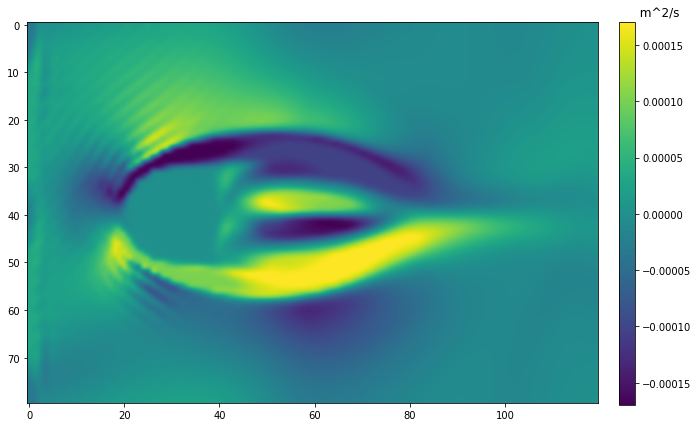

In [19]:
plt.figure(figsize=(11, 7))
plt.imshow(v1+u1,interpolation='bicubic')
cax = plt.axes([0.9, 0.12, 0.02, 0.76],title="                  m^2/s ")
plt.colorbar(cax=cax)